In [1]:
import requests
import json

import numpy as np

import astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table, vstack

from astroquery.imcce import Skybot

import matplotlib.pyplot as plt

# Objects crossing COSMOS 1 field of DDF in 2021

## DDF and COSMOS 1 Field

The Deep Drilling Field (DDF) is an optical imaging survey conducted with the Dark Energy Camera (DECam) on the 4-m Blanco telescope at the Cerro Tololo Inter-American Observatory (CTIO) repeatedly images several fields (refered to as COSMOS 1, 2 and 3 and DECals). The part of survey considered here covers the target named "COSMOS 1" over ~40 epochs (nights) per field and 5 to 6 images per night per filter in g, r, i, and/or z. The subset covers the timespan from 2021-03-19 to 2022-01-24 (21A and 21B halves). 

The survey is described in more depth in [this paper](https://ui.adsabs.harvard.edu/abs/2023MNRAS.519.3881G/abstract). 

The COSMOS 1 field is generally located at:

In [2]:
# the first is reported by FITS WCS, but the second values are better for Skybot
# The raw WCS vs fitted WCS seems much better. So we will look for a wide ADA 
# cone and use a slightly "wrong" dec_center
#ra_center = 150.00045                                                                                                                                                                                                                                                                                                                                                                        
#dec_center = 3.10005 
ra_center = 150.00045
dec_center = 3.248005

DECam and CTIO cover approximately 3 square degrees on the sky, i.e. it spans the radius of:

In [3]:
radius = 1.1 # degrees

Important note to clarify here is that within the COSMOS 1 target the provided coordinates mark the more common pointing, but there is another one neighbouring the given coordinates at:

In [4]:
ra_secondary = 149.220167
dec_secondary = 1.749694

The two pointings are two neighbouring fields. There are 126 of these alternate pointings compared to 449 primary pointings.

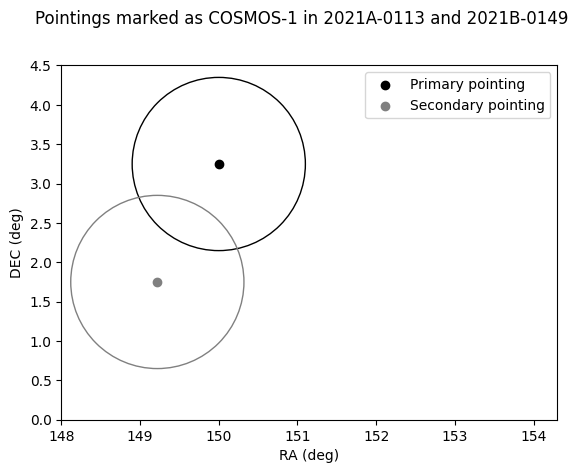

In [5]:
fig, ax = plt.subplots()
fig.suptitle("Pointings marked as COSMOS-1 in 2021A-0113 and 2021B-0149")
ax.scatter(ra_center, dec_center, color="black", label="Primary pointing")
ax.scatter(ra_secondary, dec_secondary, color="gray", label="Secondary pointing")
circ1 = plt.Circle((ra_center, dec_center), radius, fill=False, color="black")
circ2 = plt.Circle((ra_secondary, dec_secondary), radius, fill=False, color="gray")
ax.add_artist(circ1)
ax.add_artist(circ2)
ax.set_xlim(148, 154.3)
ax.set_ylim(0, 4.5)
ax.set_xlabel("RA (deg)")
ax.set_ylabel("DEC (deg)")
ax.set_aspect("equal")
_ = plt.legend()

To see this for yourself you can download one example of the alternate pointing and compare the metadata to the primary exposure metadata:

In [6]:
# To get the alternate pointing uncomment and execute cell
#!wget https://astroarchive.noirlab.edu/api/retrieve/b142b7b3b9c85d0af6552faa985983b0/

To follow along this notebook download an example of the primary pointing:

In [7]:
# To get the primary pointing uncomment and execute cell
#!wget https://astroarchive.noirlab.edu/api/retrieve/c1db52de6dad0d8a4068fdd4a8e35e1c/

We mainly need this to build the bounding boxes of a single exposure to contextualize the tracks across the field.

The exposure filters and dates in the COSMOS 1 field can be retrieved from Astro Data Archive advanced search API:

In [ ]:
payload = {
    "outfields": [
        "archive_filename",
        "dateobs_center",
        "ifilter",
    ],
    "search": [
        [
            "caldat",
            "2021-03-18", # a day less
            "2022-01-25" # a day more
        ],
        [
            "ra_center",
            ra_center-0.15, # a small range
            ra_center+0.15 # to avoid including wrong data
        ],
        [
            "dec_center", 
            dec_center-0.15,
            dec_center+0.15
        ],
        [
            "proposal", 
            "2021A-0113",
            "2021B-0149"
        ],
        [
            "instrument",
            "decam"
        ],
        [
            "proc_type",
            "raw"
        ],
        [
            "prod_type",
            "image"
        ],
    ]
}


response = requests.post("https://astroarchive.noirlab.edu/api/adv_search/find/", json=payload)
data = json.loads(response.content)

# zeroth element is the meta, parameters and header dict echoing query parameters
ada_data = Table(data[1:])

The list of known objects crossing the approximate region of the COSMOS 1 field can be retrieved by retrieving all the timestamps of the exposures and querying Skybot. The objects in the area already provided in the file `known_objects_in_cosmos_1.ecsv`, but the file can be reconstructed by executing the following cell.

In [ ]:
def download_all_known_objects(ada_data):
    collated_res = None
    ntot = len(ada_data)
    for i, row in enumerate(ada_data):
        fname = row["archive_filename"].split("/")[-1]
        band = row["ifilter"]
        datetime = row["dateobs_center"]
        
        print(f"[{i:>3}/{ntot:>3}] Querying {fname:<35}", end="    ")
        
        fmt_time = datetime.replace("T", " ").split(".")[0]
        try:
            if i==0:
                collated_res = Skybot.cone_search((ra_center, dec_center), radius, fmt_time)
                collated_res.add_column(col=datetime, name="obstime")
                collated_res.add_column(col=band, name="filter")
            else:
                tmp_res = Skybot.cone_search((ra_center, dec_center), radius, fmt_time)
                tmp_res.add_column(col=datetime, name="obstime")
                tmp_res.add_column(col=band, name="filter")
                collated_res = vstack([collated_res, tmp_res])
        except:
            collated_res.write(f"known_objects_in_cosmos_1.part_{i}.ecsv")
            print("FAILED!")
            raise
        else:
            print("Done")
            
    if collated_res is not None:
        collated_res.sort(["Name", "obstime"])
        collated_res.write("known_objects_in_cosmos_1.ecsv", overwrite=True)
    else:
        raise RuntimeError("Something went wrong no data recovered.")

#download_all_known_objects(ada_data)

## Objects transiting the FOV in 2021

In this section we'll take a peek at some of the properties of known objects that were returned in the previous section. If you're relying on the data provided in the repository, this is where you should start.

The following code assumed you have access to at least 1 example field in order to properly draw bounding boxes and that the `known_objects_in_cosmos_1.ecsv` exists as in format expected.

In [8]:
img = fits.open("c4d_210319_003604_ooi_g_v1.fits")
objects = Table.read("known_objects_in_cosmos_1.ecsv")

objects

Number,Name,RA,DEC,Type,V,posunc,centerdist,RA_rate,DEC_rate,geodist,heliodist,alpha,elong,x,y,z,vx,vy,vz,epoch,obstime,filter
,,deg,deg,,mag,arcsec,arcsec,arcsec / h,arcsec / h,AU,AU,deg,deg,AU,AU,AU,AU / d,AU / d,AU / d,d,,
int64,str15,float64,float64,str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str27,str32
443795,1917 T-3,150.66815791666664,3.88891,MB>Outer,20.8,0.069,3328.802,-23.6476,-2.467,1.49992978901,2.37448823964,14.22,143.78,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,2022-01-16T07:02:10.631327Z,g DECam SDSS c0001 4720.0 1520.0
443795,1917 T-3,150.6679658333333,3.88889,MB>Outer,20.8,0.069,3328.255,-23.6488,-2.466,1.49992484127,2.37449227412,14.22,143.78,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,2022-01-16T07:03:55.089907Z,r DECam SDSS c0002 6415.0 1480.0
443795,1917 T-3,150.66771708333332,3.8888641666666666,MB>Outer,20.8,0.069,3327.546,-23.6502,-2.465,1.49991843321,2.37449749974,14.22,143.78,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,2022-01-16T07:06:11.438496Z,i DECam SDSS c0003 7835.0 1470.0
443795,1917 T-3,150.66615666666667,3.8887019444444446,MB>Outer,20.8,0.069,3323.102,-23.6596,-2.461,1.49987825316,2.3745302754,14.21,143.79,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,2022-01-16T07:20:24.641723Z,g DECam SDSS c0001 4720.0 1520.0
443795,1917 T-3,150.66596999999996,3.8886825,MB>Outer,20.8,0.069,3322.571,-23.6607,-2.46,1.49987344986,2.37453419467,14.21,143.79,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,2022-01-16T07:22:06.613046Z,r DECam SDSS c0002 6415.0 1480.0
443795,1917 T-3,150.66571749999997,3.8886563888888888,MB>Outer,20.8,0.069,3321.852,-23.6622,-2.459,1.49986695173,2.37453949723,14.21,143.8,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,2022-01-16T07:24:24.251378Z,i DECam SDSS c0003 7835.0 1470.0
443795,1917 T-3,150.34008041666667,3.86233,MB>Outer,20.8,0.069,2526.032,-25.4882,-1.525,1.49221220225,2.38112932255,13.4,146.02,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,2022-01-18T06:59:11.188687Z,g DECam SDSS c0001 4720.0 1520.0
443795,1917 T-3,150.33987916666666,3.862318055555556,MB>Outer,20.8,0.069,2525.645,-25.4893,-1.524,1.49220789165,2.38113325157,13.4,146.02,-1.67321661,1.575654874,0.475218436,-0.010445384,-0.00510659,-0.003650771,2459590.0,2022-01-18T07:00:53.458507Z,r DECam SDSS c0002 6415.0 1480.0


In [62]:
def iter_over_obj(objects):
    """Folds the given list of objects on their ``Name``s and
    iterates over them sorted by date-time stamp.
                
    Parameters
    -----------
    objects : `astropy.table.Table`
        Table of objects.
        
    Returns
    --------
    obj : `iterator`
        Iterator over individual object observations.
    """
    names = set(objects["Name"])
    for name in names:
        obj = objects[objects["Name"] == name]
        obj.sort("obstime")
        yield obj

def transform_rect(points):
    """Given a rectangle defined by 4 points (clockwise convention)
    returns top-left point, width, height, and angle of rectangle.
    
    Parameters
    ----------
    points : `list`
        List of 4 tuples representing (x, y) coordinates of the
        corners of a rectanlge, in clockwise convention.
        
    Returns
    -------
    xy : `tuple`
        Top left corner (x, y) coordinates.
    width : `float`
        Width
    height : `float`
        Height
    angle : `float`
        Angle of rotation, in radians.
    """
    calc_dist = lambda p1, p2: np.sqrt( (p1[0] - p2[0])**2 + ( p1[1] - p2[1])**2 )
    calc_angle = lambda p1, p2: np.arctan2(p2[1] - p1[1], p2[0] - p1[0])
    
    # flip height so the xy becomes top left, then we don't have to guess
    # which point we need to return
    width = calc_dist(points[0], points[1])
    height = calc_dist(points[1], points[2])
    xy = points[0]
    
    angle = calc_angle(points[-1], points[0])
    
    return xy, width, height, angle
        
def plot_field(ax, center, radius, figure=None):
    """Adds a circle of the given radius and the origin at the given
    center coordinates to the given axis."""
    ax.scatter(*center, color="black", label="Pointing area")
    circ = plt.Circle(center, radius, fill=False, color="black")
    ax.add_artist(circ)
    return ax
    
def plot_footprint(ax, wcs, figure=None):
    """Adds the footprint defined by the given WCS to the axis."""
    xy, width, height, angle = transform_rect(wcs.calc_footprint())
    rect = plt.Rectangle(xy, width, height, angle=angle, fill=None, color="black")
    ax.add_artist(rect)
    return ax
    
def plot_footprints(ax, wcs_list, figure=None):
    """Adds the footprints defined by each given WCS to the axis."""
    for wcs in wcs_list:
        ax = plot_footprint(ax, wcs, figure)
    return ax
    
def plot_all_objs(ax, objects, count=0, show_field=False, 
                  center=(ra_center, dec_center), radius=1.1, 
                  lw=0.9, ms=1, figure=None):
    """Plots object tracks on the given axis.
    
    Parameters
    ----------
    ax : `matplotlib.pyplot.Axes`
        Axis.
    objects : `astropy.table.Table`
        Table of objects.
    count : `int`
        Number of tracks to plot.
    show_field : `bool`
        Show approximate COSMOS 1 field.
        
    Returns
    -------
    ax : `matplotlib.pyplot.Axes`
        Axis.
    """
    if show_field:
        plot_field(ax, center, radius)
        
    for i, obj in enumerate(iter_over_obj(objects)):
        if count > 0 and i == count:
            break
        ax.plot(obj["RA"], obj["DEC"], label=obj["Name"][0], marker="o", lw=lw, ms=ms)
        
    if figure is not None:
        return ax, figure
    return ax

def plot_focal_plane(ax, hdulist, figure=None):
    """Plots the footprint of given HDUList on the axis."""
    wcss = [WCS(hdu.header) for hdu in hdulist]
    # I really wish that WCS would pop an error when unable to 
    # init from a header instead of defaulting, oh, and __eq__ 
    # doesn't compare naturally
    default_wcs = WCS().to_header_string()
    for hdu in hdulist:
        wcs = WCS(hdu.header)
        if default_wcs != wcs.to_header_string():
            ax = plot_footprint(ax, wcs)
        
    #ax = plot_footprints(ax, wcss)
    return ax

In [38]:
unique_names = set(objects["Name"])
types = set(objects["Type"])
hdist = np.array([o["heliodist"][0] for o in iter_over_obj(objects)])

There are 2517 unique known objects crossing the fov, sorted into 10 categories:
    Hungaria
    MB>Outer
    MB>Inner
    NEA>Amor
    MB>Cybele
    Mars-Crosser
    NEA>Apollo
    MB>Hilda
    MB>Middle
    KBO>Classical>Main
There is/are 1 objects marked as KBO>Classical>Main, named:
    2008 AQ118


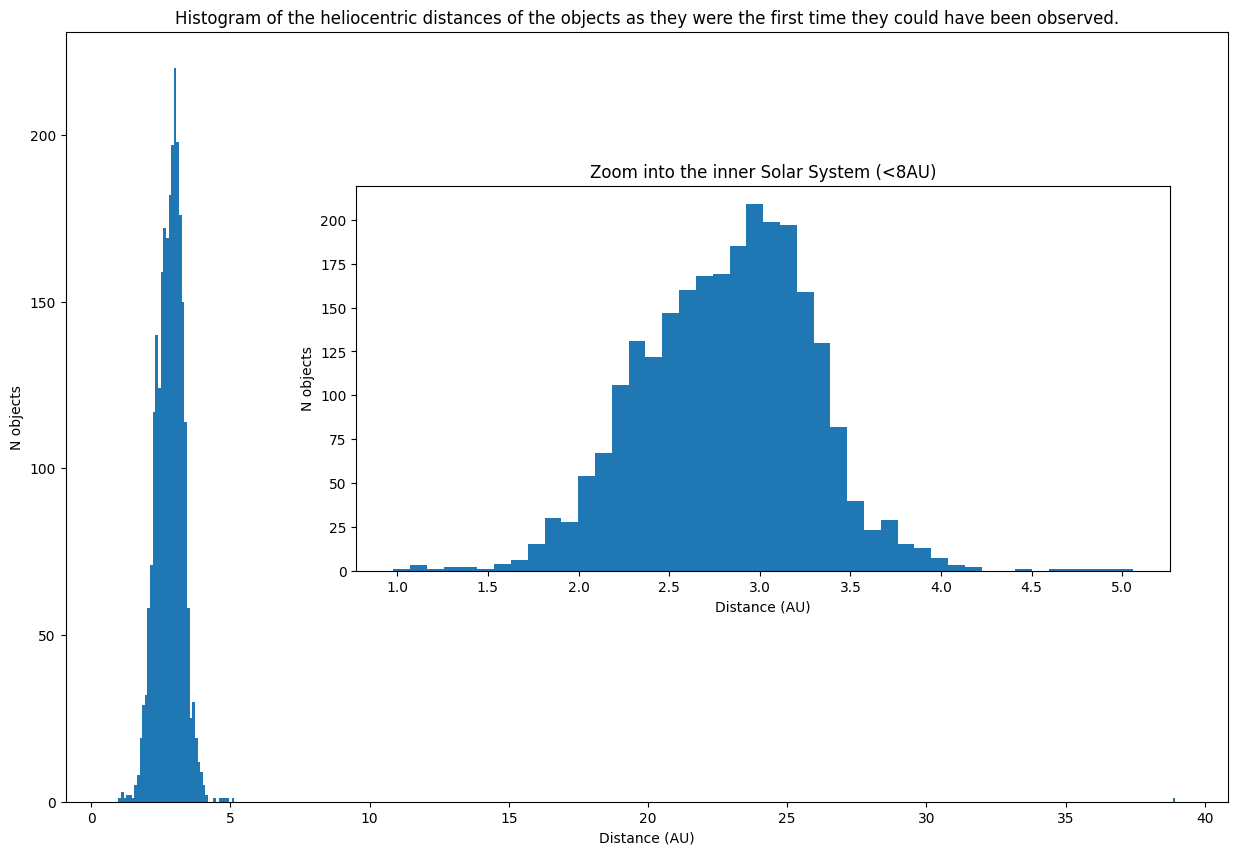

In [60]:
print(f"There are {len(unique_names)} unique known objects crossing the fov, sorted into {len(types)} categories:")
for t in types:
    print(f"    {t}")

kbos = objects[objects['Type'] == 'KBO>Classical>Main']
kbo_names = set(kbos['Name'])
print(f"There is/are {len(kbo_names)} objects marked as KBO>Classical>Main, named:")
for n in kbo_names:
    print(f"    {n}")
    
# See https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html#numpy.histogram_bin_edges
fig, ax = plt.subplots(figsize=(15, 10))

ax.hist(hdist, bins="auto")
inset_ax = ax.inset_axes([0.25, 0.3, 0.7, 0.5])
inset_ax.hist(hdist[hdist<8], bins="auto")

inset_ax.set_title("Zoom into the inner Solar System (<8AU)")
inset_ax.set_ylabel("N objects")
inset_ax.set_xlabel("Distance (AU)")

ax.set_title("Histogram of the heliocentric distances of the objects as they were the first time they could have been observed.")
ax.set_ylabel("N objects")
_ = ax.set_xlabel("Distance (AU)")

A total of 33388 known objects could have been observed in `i` filter.


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


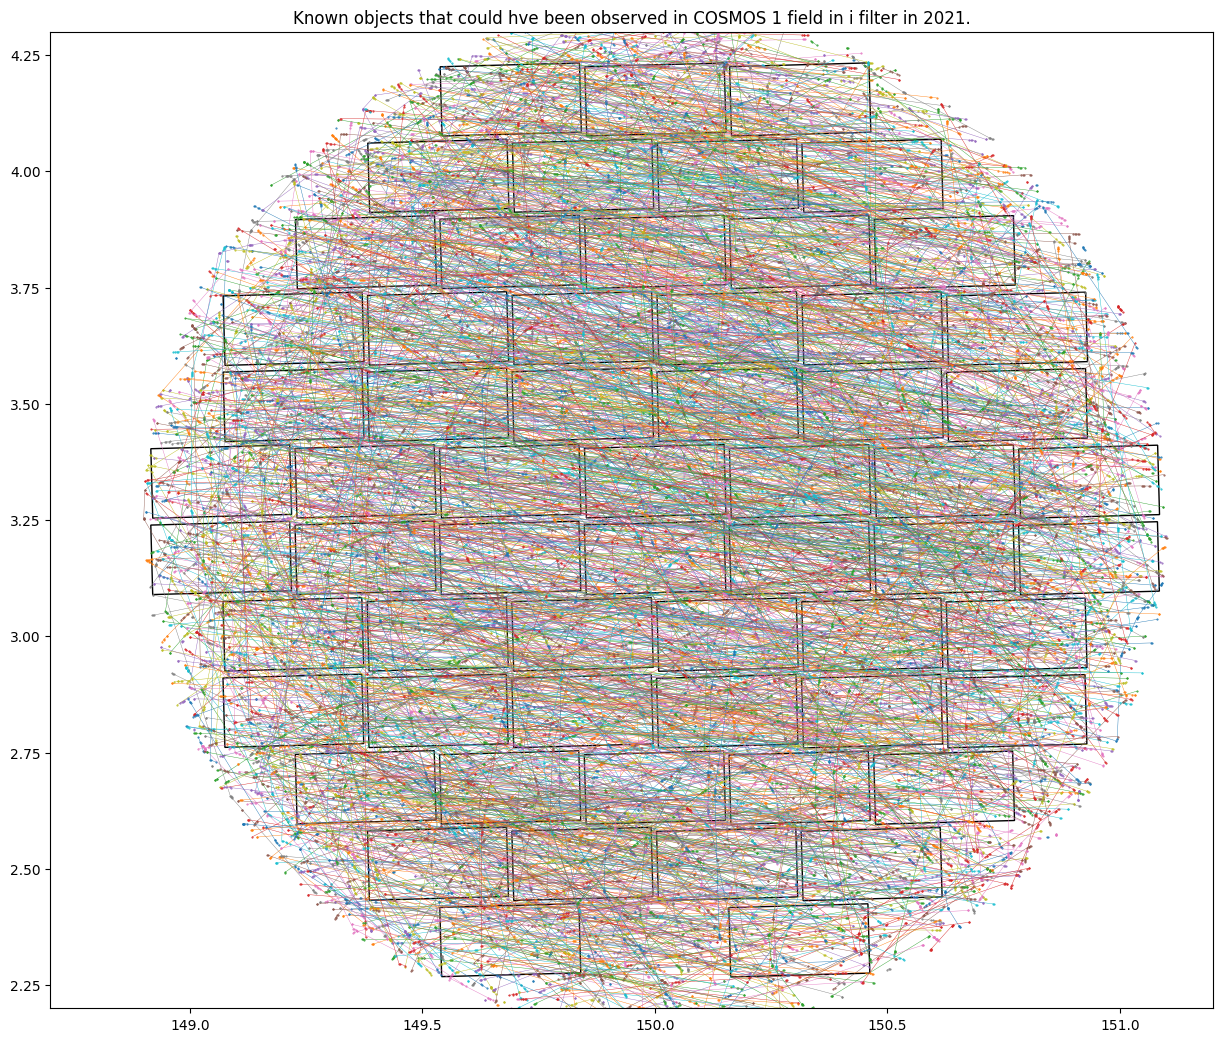

In [64]:
fig, ax = plt.subplots(figsize=(15, 15))

ra_center = 150.00045
dec_center = 3.10005
radius = 1.1 # degrees

i_filter_only = objects[objects["filter"] == "i DECam SDSS c0003 7835.0 1470.0"]
print(f"A total of {len(i_filter_only)} known objects could have been observed in `i` filter.")
plot_focal_plane(ax, img)
plot_all_objs(ax, i_filter_only, show_field=False, lw=0.3, ms=0.5)

ax.set_title("Known objects that could hve been observed in COSMOS 1 field in i filter in 2021.")
ax.set_xlim(148.7, 151.2)
ax.set_ylim(2.2, 4.3)
ax.set_aspect("equal")

The 2008 AQ118 KBO could have been observed a total of 66 times in any filter.


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


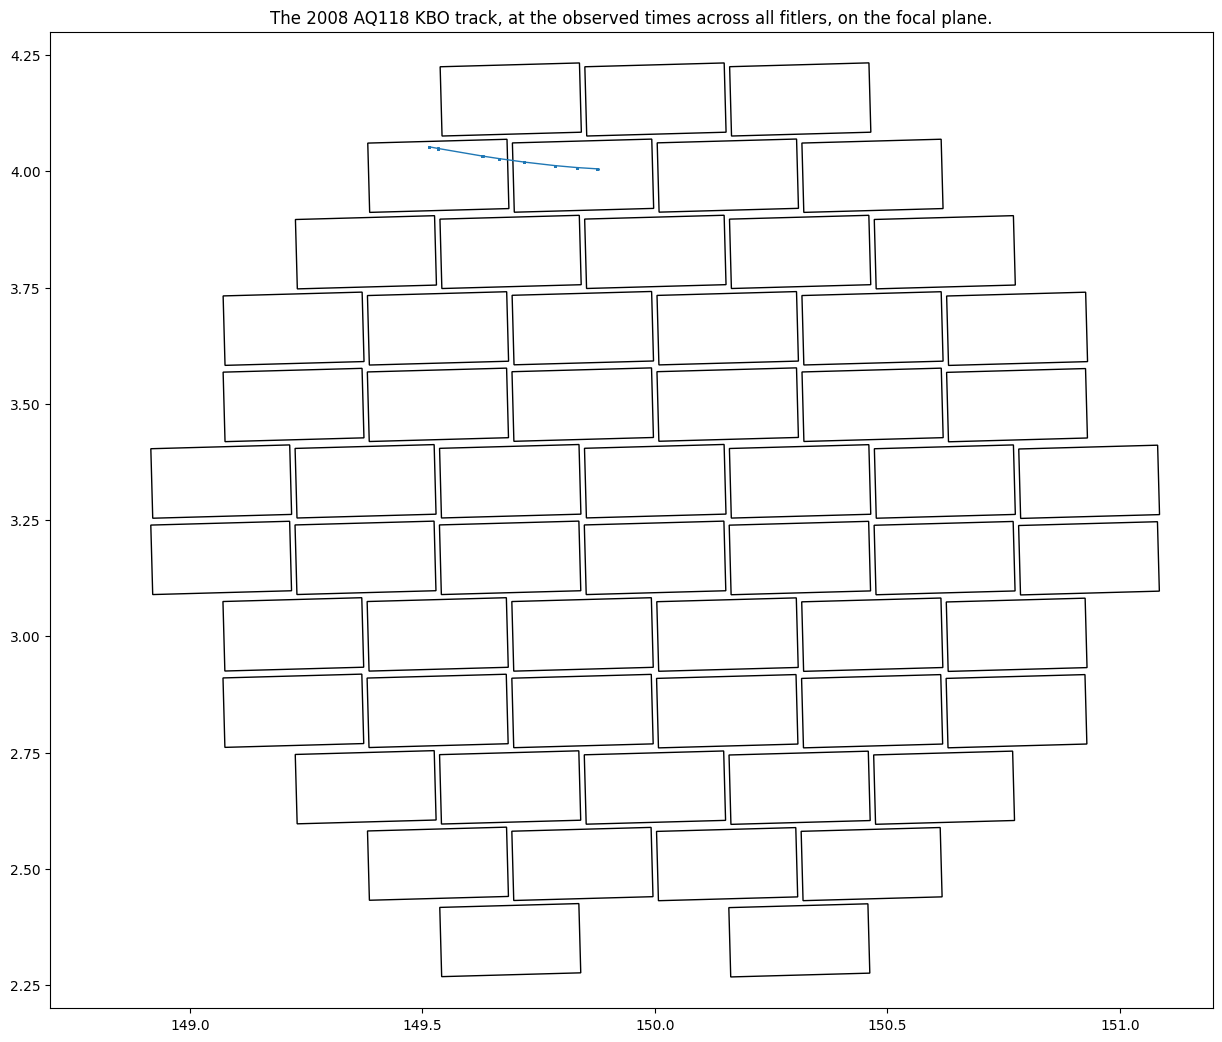

In [66]:
fig, ax = plt.subplots(figsize=(15, 15))

ra_center = 150.00045
dec_center = 3.10005
radius = 1.1 # degrees

kbo_only = objects[objects["Name"] == "2008 AQ118"]
print(f"The 2008 AQ118 KBO could have been observed a total of {len(kbo_only)} times in any filter.")
plot_focal_plane(ax, img)
plot_all_objs(ax, kbo_only, show_field=False, lw=1, ms=1.1)

ax.set_title("The 2008 AQ118 KBO track, at the observed times across all fitlers, on the focal plane.")
ax.set_xlim(148.7, 151.2)
ax.set_ylim(2.2, 4.3)
ax.set_aspect("equal")